In [13]:
import numpy as np
import torch
import sys
sys.path.append('../')
from voting_games.werewolf_env_v0 import plurality_env, Roles, Phase
from notebooks.learning_agents.models import ActorCriticAgent
from notebooks.learning_agents.utils import play_static_game, play_recurrent_game
from notebooks.learning_agents.static_agents import (
    random_plurality_villager, 
    random_coordinated_plurality_villager, 
    random_agent,
    random_plurality_wolf,
    revenge_plurality_wolf,
    coordinated_revenge_plurality_wolf)
import notebooks.learning_agents.stats as indicators
import random
import copy
from matplotlib import pyplot as plt
from tqdm import tqdm
from tabulate import tabulate

# Plurality Voting

Plurality is a voting method where each voter picks a single candidate, and the candidate with the most votes is selected. It's simplicity has lead to wide adoption, however there are quite a few drawbacks, one of which being the limited expressibility of a voter.

In our Werewolf plurality implementation, an agent can only select a single target, and cannot express their beliefs towards the remaining agents. This is also the voting mechanism used in every paper involving the Werewolf game up to now, so we want to see how our trained agents compare.


## Win Rates

We want to see how our hand-crafted agents play against eachother, with special interest given to coordinated random villagers and wolves. 

As expected, the coordinated random villagers and wolves performed the best out of the static policies {cite}`braverman2008mafia`.
Our agent, trained against coordinated random wolves, performed better than all of our hand-crafted villager policies. They also generalized well against our other wolf policies, and actually had the highest win rates across the board.

Below is code to generate the following table of 1000 runs between each villager policy and each werewolf policy. We base our discussion around this markdown table.

Villager Strategy vs. | [RWolves](rpwolves) | [CRWolves](crpwolves) | [RevWolves](revpwolves) | [CRevWolves](crevpwolves)
| --- | --- | --- | --- | --- | 
Totally Random | 0.597 | 0.042 | 0.076 | 0.074 |
Random Targetting of living villagers | 0.705 | 0.125 | 0.192 | 0.244 |
Coorindated random targetting | 0.653 | 0.314 | 0.304 | 0.281 |
Trained villagers | 0.83 | 0.473| 0.45 | 0.503 |

In [6]:
env = plurality_env(num_agents=10, werewolves=2, num_accusations=2)
observations, _, _, _, _ = env.reset()

obs_size= env.convert_obs(observations['player_0']['observation']).shape[-1]

trained_plurality_agent = ActorCriticAgent({"rec_hidden_size": 128,
                                        "rec_layers": 1, 
                                        "joint_mlp_size": 128,
                                        "split_mlp_size": 128,
                                        "num_votes": 1,
                                        "approval_states": 10},
                                        num_players=10,
                                        obs_size=obs_size)
trained_plurality_agent.load_state_dict(torch.load("../notebooks/stored_agents/lstm_first_no_one_hot_128_128/plurality_agent_10_score_46"))

num_games = 1000
print(f'10 players, with 2 wolves - number of games played : {num_games} \n')

rv_wins = []
rv_replays = []
for wolf_policy in [random_agent, random_plurality_wolf, revenge_plurality_wolf, coordinated_revenge_plurality_wolf]:
    wins, replays = play_static_game(env, wolf_policy, random_agent, num_times=num_games)
    rv_wins.append(wins/float(num_games))
    rv_replays.append(replays)

rpv_wins = []
rpv_replays = []
for wolf_policy in [random_agent, random_plurality_wolf, revenge_plurality_wolf, coordinated_revenge_plurality_wolf]:
    wins, replays = play_static_game(env, wolf_policy, random_plurality_villager, num_times=num_games)
    rpv_wins.append(wins/float(num_games))
    rpv_replays.append(replays)

cpv_wins = []
cpv_replays = []
for wolf_policy in [random_agent, random_plurality_wolf, revenge_plurality_wolf, coordinated_revenge_plurality_wolf]:
    wins, replays = play_static_game(env, wolf_policy, random_coordinated_plurality_villager, num_times=num_games)
    cpv_wins.append(wins/float(num_games))
    cpv_replays.append(replays)

tpv_wins = []
tpv_replays = []
for wolf_policy in [random_agent, random_plurality_wolf, revenge_plurality_wolf, coordinated_revenge_plurality_wolf]:
    # wins, replays = play_static_game(env, wolf_policy, random_agent, num_times=num_games)[0]/float(num_games)
    wins, replays = play_recurrent_game(env, wolf_policy, trained_plurality_agent, num_times=num_games, hidden_state_size=128, voting_type="plurality")
    tpv_wins.append(wins/float(num_games))
    tpv_replays.append(replays)

print(tabulate([['Totally Random', *rv_wins], 
                ['Random Targetting of living villagers', *rpv_wins], 
                ['Coorindated random targetting', *cpv_wins], 
                ['Trained villagers', *tpv_wins]], 
               headers=["Villager Strategy", 
                        "Totally Random Wolves", 
                        "Coordinated Random Wolves", 
                        "Revenge Wolves",
                        "Coordinated Revenge Wolves"]))

10 players, with 2 wolves - number of games played : 1000 

Villager Strategy                        Totally Random Wolves    Coordinated Random Wolves    Revenge Wolves    Coordinated Revenge Wolves
-------------------------------------  -----------------------  ---------------------------  ----------------  ----------------------------
Totally Random                                           0.597                        0.042             0.076                         0.074
Random Targetting of living villagers                    0.705                        0.125             0.192                         0.244
Coorindated random targetting                            0.653                        0.314             0.304                         0.281
Trained villagers                                        0.83                         0.473             0.45                          0.503


## Indicators

We base our analysis overview 

### Days elapsed before a villager win

In [27]:
tpv_win_replays = [r for r in tpv_replays[1] if r[-1]["winners"] == Roles.VILLAGER]
rv_win_replays = [r for r in rv_replays[1] if r[-1]["winners"] == Roles.VILLAGER]
rpv_win_replays = [r for r in rpv_replays[1] if r[-1]["winners"] == Roles.VILLAGER]
cpv_win_replays = [r for r in cpv_replays[1] if r[-1]["winners"] == Roles.VILLAGER]

print("Average amount of days until a win is achieved by villagers in plurality games")
print(f'\t Trained villagers : {np.mean([villager_win[-1]["day"] for villager_win in tpv_win_replays]):.2f}')
print(f'\t Random Coordinated Villagers : {np.mean([villager_win[-1]["day"] for villager_win in cpv_win_replays]):.2f}')
print(f'\t Random Living Villagers : {np.mean([villager_win[-1]["day"] for villager_win in rpv_win_replays]):.2f}')
print(f'\t Totally Random Villagers : {np.mean([villager_win[-1]["day"] for villager_win in rv_win_replays]):.2f}')

Average amount of days until a win is achieved by villagers in plurality games
	 Trained villagers : 2.88
	 Random Coordinated Villagers : 3.49
	 Random Living Villagers : 3.50
	 Totally Random Villagers : 3.36


We had mentioned that this days elapsed indicator is a quick litmus test for any learned improvements, and we can see that the trained agent is quicker on average.

### Days between wolf executions

In [28]:
print("Average amount of days until the next wolf was killed in plurality games for 2 wolf environments")
wolf_execution_days = \
    [indicators._when_did_wolves_get_killed(trained_villager_win) for trained_villager_win in tpv_win_replays]
wolf_execution_duration_between = [b-a for a,b in wolf_execution_days]
print(f'\tDays between wolf kills for trained agents : {np.mean(wolf_execution_duration_between):.3f}')
wolf_execution_days = \
    [indicators._when_did_wolves_get_killed(trained_villager_win) for trained_villager_win in cpv_win_replays]
wolf_execution_duration_between = [b-a for a,b in wolf_execution_days]
print(f'\tDays between wolf kills for CPV agents : {np.mean(wolf_execution_duration_between):.3f}')
wolf_execution_days = \
    [indicators._when_did_wolves_get_killed(trained_villager_win) for trained_villager_win in rpv_win_replays]
wolf_execution_duration_between = [b-a for a,b in wolf_execution_days]
print(f'\tDays between wolf kills for RPV agents : {np.mean(wolf_execution_duration_between):.3f}')
wolf_execution_days = \
    [indicators._when_did_wolves_get_killed(trained_villager_win) for trained_villager_win in rv_win_replays]
wolf_execution_duration_between = [b-a for a,b in wolf_execution_days]
print(f'\tDays between wolf kills for random agents : {np.mean(wolf_execution_duration_between):.3f}')

Average amount of days until the next wolf was killed in plurality games for 2 wolf environments
	Days between wolf kills for trained agents : 1.529
	Days between wolf kills for CPV agents : 1.640
	Days between wolf kills for RPV agents : 1.696
	Days between wolf kills for random agents : 1.857


This number is one we also expected to be lower, but it won't be as drastic in a 10 player game due to the shortness of games. At most we have $5$ days. Regardless, a lower number means the agents are better at identifying duplicitous werewolf players.

### Ties

In [30]:
print("Plurality tie indicators")

for names, win_replays in zip(["trained", "cpv", "rpv", "random"], [tpv_win_replays, cpv_win_replays, rpv_win_replays, rv_win_replays]):
    tgps = \
        np.nanmean(np.stack([indicators._process_tie_info(indicators._game_tie_info(trained_villager_win, voting_type="plurality")) for trained_villager_win in win_replays]),axis= 0)
    print(f'{names} agent tie indicators')
    print(f'\tLikelihood of ties in accusation phases : {tgps[0]:.2f}')
    print(f'\tLikelihood of ties in voting phases : {tgps[1]:.2f}')
    print(f'\tLikelihood of a tie in a voting phase given a tie in the prior accusation phases {tgps[2]:.2f}')
    print(f'\tLikelihood of a wolf getting targetting in a subsequent voting round if they survived a tie : {tgps[3]:.2f}')
    print("\n")



Plurality tie indicators
trained agent tie indicators
	Likelihood of ties in accusation phases : 0.29
	Likelihood of ties in voting phases : 0.19
	Likelihood of a tie in a voting phase given a tie in the prior accusation phases 0.18
	Likelihood of a wolf getting targetting in a subsequent voting round if they survived a tie : 0.70


cpv agent tie indicators
	Likelihood of ties in accusation phases : 0.00
	Likelihood of ties in voting phases : 0.00
	Likelihood of a tie in a voting phase given a tie in the prior accusation phases nan
	Likelihood of a wolf getting targetting in a subsequent voting round if they survived a tie : nan


rpv agent tie indicators
	Likelihood of ties in accusation phases : 0.38
	Likelihood of ties in voting phases : 0.44
	Likelihood of a tie in a voting phase given a tie in the prior accusation phases 0.48
	Likelihood of a wolf getting targetting in a subsequent voting round if they survived a tie : 0.57


random agent tie indicators
	Likelihood of ties in accu

/tmp/ipykernel_17947/2466167984.py:5: RuntimeWarning: Mean of empty slice
  np.nanmean(np.stack([indicators._process_tie_info(indicators._game_tie_info(trained_villager_win, voting_type="plurality")) for trained_villager_win in win_replays]),axis= 0)


Having less ties in accusation phases can indicate more coordination, and a lower number of ties in the voting phase can indicate synthesis of information over the accusation rounds. Learning agents also have a much lower chance of having a tie in a voting round if there was a tie in the accusation round, further solidifying this notion of accusation information synthesis. 

For follow up targetting of wolves who survived tie rounds, the higher the number, the better. Again we can see learning agents doing this much more often than random agents.



### Targetting Indicators

As a reminder, our indicators are averaged and stacked, with the following indicators in order:
- _unique targets_
- _self vote_
- _percentage of targets towards wolves_ 
- _percentage of targets towards dead players_ 
- _percentage of targets torwards dead wolves_

There are trends across phases in a day, and trends across days we look at. Our stacked records have a shape of `(day, phase, indicators)`, which we can slice in many directions

In [92]:
tpv_avg_records = indicators._game_avg_records(tpv_replays[1], indicators._plurality_target_indicators)
cpv_avg_records = indicators._game_avg_records(cpv_replays[1], indicators._plurality_target_indicators)
rv_avg_records = indicators._game_avg_records(rv_replays[1], indicators._plurality_target_indicators)

tpv_stacked = np.stack(list(tpv_avg_records.values()))
cpv_stacked = np.stack(list(cpv_avg_records.values()))
rv_stacked = np.stack(list(rv_avg_records.values()))

In [95]:
tpv_stacked[:,:,0] # unique votes across days and phases
tpv_stacked[:,:,1] # self votes across days and phases
tpv_stacked[:,:,2] # percent of targets towards wolves
tpv_stacked[:,:,3] # percent of targets towards dead players
tpv_stacked[:,:,4] # percent of targets towards dead wolves
print(tpv_stacked.shape)

(4, 3, 5)


[[0.         0.         0.        ]
 [0.05428571 0.01771429 0.01028571]
 [0.04512195 0.02243902 0.01487805]
 [0.08797654 0.05083089 0.02248289]]


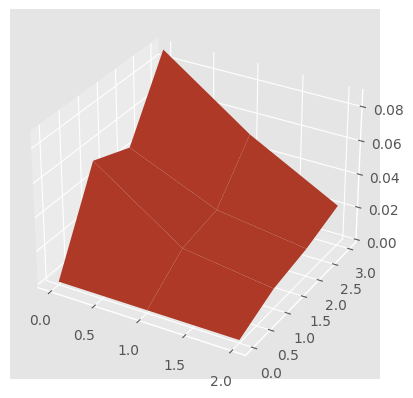

In [97]:
print(tpv_stacked[:,:,4])

t = [0,1,2,3]
x = [0,1,2]

xx, yy = np.meshgrid(x,t)
plt.style.use('ggplot')

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(xx,yy,tpv_stacked[:,:,4])
plt.show()

The above figure shows us the percentage of targets towards dead wolves for trained agents across phases and days. We expect this number to grow as the days go on, but as we can see, it stays below $0.1$, and decreases as we get towards the voting phase for each day. The trained agent almost never targets a dead wolf, and even less so when it comes time to execute a player. 

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


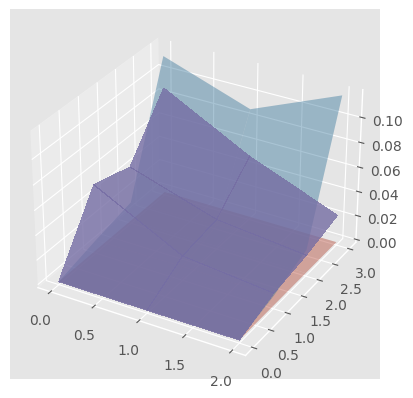

In [116]:
print(cpv_stacked[:,:,4])

t = [0,1,2,3]
x = [0,1,2]

xx, yy = np.meshgrid(x,t)
plt.style.use('ggplot')

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(xx,yy,cpv_stacked[:,:,4], alpha=0.4)
surf = ax.plot_surface(xx,yy,rv_stacked[:,:,4], alpha=0.4)
surf = ax.plot_surface(xx,yy,tpv_stacked[:,:,4], alpha=0.8, antialiased=False)
# ax.view_init(30, 20)
plt.show()

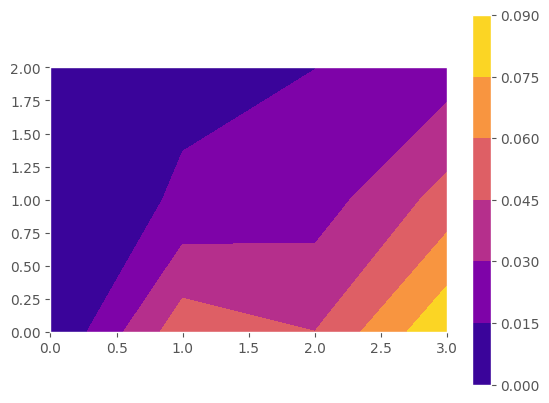

In [105]:
fig = plt.figure()
plt.contourf(yy,xx,tpv_stacked[:,:,4], cmap="plasma")
plt.axis('scaled')
plt.colorbar()
plt.show()

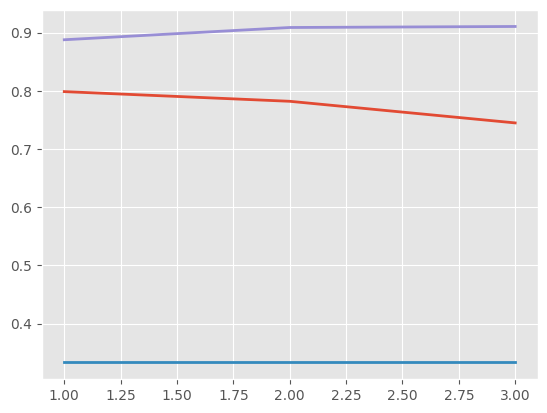

In [23]:
plt.style.use('ggplot')

# make data
x = [1,2,3]
y = tpv_stacked[:,:,0][3]

# plot
fig, ax = plt.subplots()

# ax.plot(x, y, linewidth=2.0)
ax.plot(x, tpv_stacked[:,:,0][3], linewidth=2.0)
ax.plot(x, cpv_stacked[:,:,0][3], linewidth=2.0)
ax.plot(x, rv_stacked[:,:,0][3], linewidth=2.0)

# ax.set(xlim=(0, 8), xticks=np.arange(1, 8),
#        ylim=(0, 8), yticks=np.arange(1, 8))

plt.show()